# Anomaly detection
### NASA acoustics and vibration- Autoencoder

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.12.25 </div> 
<div style="text-align: right"> Last update: 2020.12.25</div> 

NASA의Acoustics and Vibration Database를 사용한다.  
Autoencoder를 사용한 이상탐지 기법을 살펴본다.

참고자료
- https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/  
- https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection  
- https://github.com/mhmd-ah/Anomaly_Detection  
- https://www.kaggle.com/rkuo2000/nasa-bearing-sensor-data/notebooks

### 0. 라이브러리 import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
mpl.rcParams['figure.figsize'] = (12, 5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
color_pal = [ '#ee4035', '#3385c6', '#fed766','#eb6841', '#708090', '#00a0b0', '#3b7dd8', '#fe4a49' , 
             '#2ab7ca', '#851e3e', '#2a4d69',  '#f7f7f7', '#edc951', '#54b2a9', '#ffffff', '#96ceb4', 
             '#ffeead', '#708090', '#be9b7b', '#feb2a8','#58668b',  '#4f372d', '#ECD59F', '#ABD1DC', 
             '#7E9680', '#E69D45', '#D4CFC9', '#E79796', '#C6C09C', '#dec3c3','#4b86b4', '#f9caa7', 
             '#d2d4dc', '#ebf4f6', '#29a8ab' ]

### 2. 데이터셋 살펴보기

In [4]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/bearing_sensor_data.csv'
merged_data = pd.read_csv(url, index_col=0, parse_dates=[0])

데이터 기본정보 살펴보기

In [5]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [6]:
merged_data.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060765,0.074233,0.076832,0.043950
50%,0.062007,0.075203,0.078197,0.044524
75%,0.083223,0.077456,0.080600,0.048111
max,0.453335,0.161016,0.151299,0.119047


전체 데이터 시각화

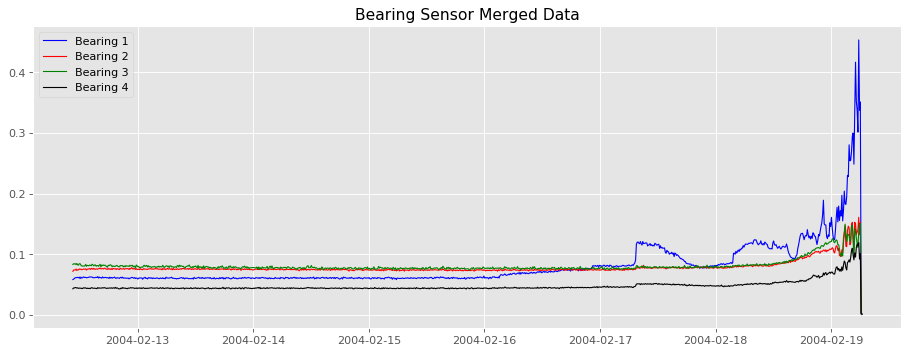

In [7]:
fig, ax = plt.subplots(figsize=(14, 5), dpi = 80)
ax.plot(merged_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(merged_data['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(merged_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(merged_data['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='best')
ax.set_title('Bearing Sensor Merged Data', fontsize=14)
plt.show()

### 3. 학습/ 시험데이터 분리하기

In [8]:
train = merged_data['2004-02-12 10:52:39': '2004-02-13 23:52:39']
test = merged_data['2004-02-13 23:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (223, 4)
Test dataset shape: (760, 4)


학습데이터 시각화하기

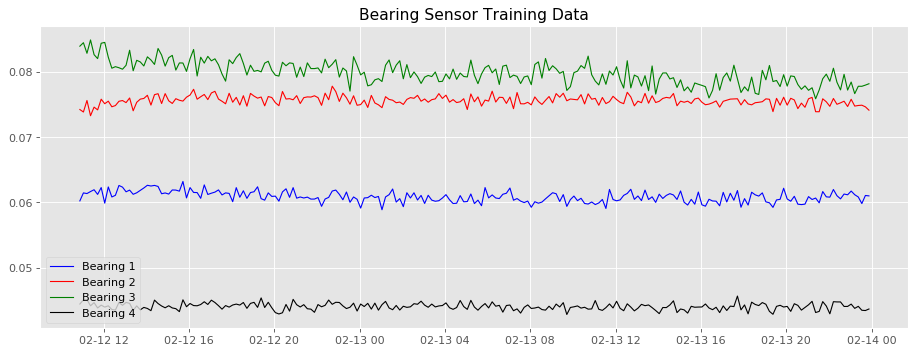

In [9]:
fig, ax = plt.subplots(figsize=(14, 5), dpi = 80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=14)
plt.show()

### 4. 데이터 정규화

MinMax 스케일러로 데이터 정규화

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index = train.index)
X_test = pd.DataFrame(scaler.transform(test), columns=test.columns, index = test.index)

In [12]:
X_train.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.313162,0.209598,0.894216,0.568334
2004-02-12 11:02:39,0.594640,0.125020,0.953188,0.794650
2004-02-12 11:12:39,0.572777,0.515185,0.773329,0.807756
2004-02-12 11:22:39,0.642988,0.000000,1.000000,0.472299
2004-02-12 11:32:39,0.707427,0.290580,0.749966,0.644737


### 5. Autoencoder를 사용한 이상탐지

In [13]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import regularizers

from numpy.random import seed
from tensorflow.random import set_seed

from tensorflow.keras.utils import plot_model

In [14]:
seed(10)
set_seed(10)

모델 생성

In [15]:
model = Sequential()
model.add(Dense(units = 10, activation = 'relu', kernel_initializer='glorot_uniform', 
                kernel_regularizer=regularizers.l2(0.0), input_shape = (X_train.shape[1], )))
model.add(Dense(units =2, activation='relu', kernel_initializer= 'glorot_uniform'))
model.add(Dense(units =2, activation='relu', kernel_initializer= 'glorot_uniform'))
model.add(Dense(10, activation='relu', kernel_initializer='glorot_uniform'))

model.add(Dense(units = X_train.shape[1], kernel_initializer='glorot_uniform'))

In [16]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 44        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


모델학습하기

In [18]:
NUM_EPOCHS=100
BATCH_SIZE=10

In [19]:
history = model.fit(X_train, X_train, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, validation_split=0.05, verbose = 1)

Epoch 1/100
22/22 [==============================] - 1s 34ms/step - loss: 0.3910 - accuracy: 0.1828 - val_loss: 0.1814 - val_accuracy: 0.0833
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2536 - accuracy: 0.3965 - val_loss: 0.1479 - val_accuracy: 0.0833
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.2036 - accuracy: 0.3642 - val_loss: 0.1336 - val_accuracy: 0.0833
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.2021 - accuracy: 0.3706 - val_loss: 0.1191 - val_accuracy: 0.0833
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1778 - accuracy: 0.3861 - val_loss: 0.1044 - val_accuracy: 0.0833
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.4269 - val_loss: 0.0906 - val_accuracy: 0.0833
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1399 - accuracy: 0.3978 - val_loss: 0.0782 - val_accuracy: 0.0833
Epoch 8/100


22/22 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.3724 - val_loss: 0.0213 - val_accuracy: 0.0000e+00
Epoch 57/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.3882 - val_loss: 0.0210 - val_accuracy: 0.0000e+00
Epoch 58/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.3379 - val_loss: 0.0210 - val_accuracy: 0.0000e+00
Epoch 59/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.3558 - val_loss: 0.0211 - val_accuracy: 0.0000e+00
Epoch 60/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 0.3750 - val_loss: 0.0208 - val_accuracy: 0.0000e+00
Epoch 61/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.4121 - val_loss: 0.0208 - val_accuracy: 0.0000e+00
Epoch 62/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.3779 - val_loss: 0.0208 - val_accuracy: 0.

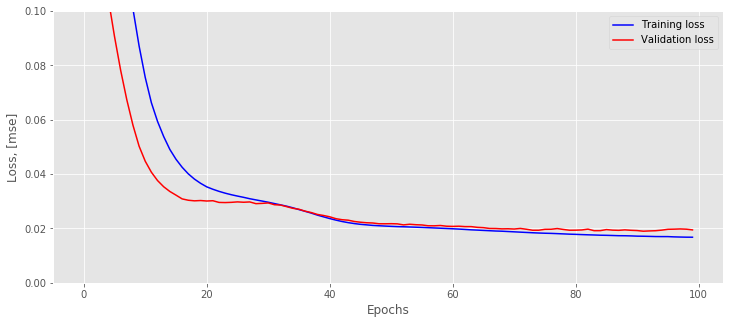

In [20]:
plt.plot(history.history['loss'],'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

학습데이터 loss 분포 살펴보기

(0.0, 0.5)

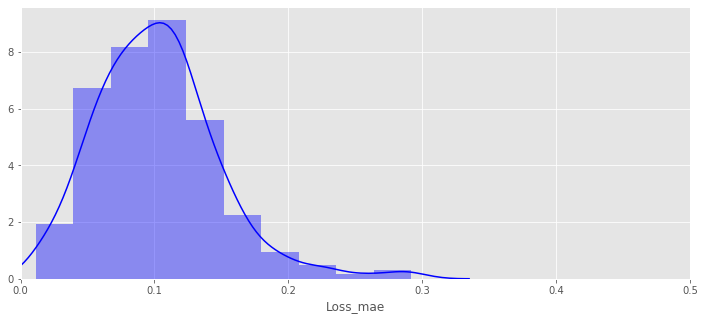

In [21]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(data=X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

plt.figure()
sns.distplot(scored['Loss_mae'], bins = 10, kde= True, color = 'blue');
plt.xlim([0.0,.5])

- Threshold를 0.3으로 설정한다.

시험데이터로 이상탐지하기

In [22]:
X_pred = model.predict(X_test)
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

In [23]:
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.125985,0.3,False
2004-02-14 00:02:39,0.105208,0.3,False
2004-02-14 00:12:39,0.038457,0.3,False
2004-02-14 00:22:39,0.119550,0.3,False
2004-02-14 00:32:39,0.122027,0.3,False


학습데이터와 시험데이터 결과 합치기

In [24]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [25]:
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-12 10:52:39,0.257326,0.3,False
2004-02-12 11:02:39,0.282843,0.3,False
2004-02-12 11:12:39,0.154593,0.3,False
2004-02-12 11:22:39,0.291634,0.3,False
2004-02-12 11:32:39,0.155370,0.3,False


시험결과 평가하기

In [26]:
scored[scored['Anomaly']==True]

,Loss_mae,Threshold,Anomaly
2004-02-15 05:42:39,0.305378,0.3,True
2004-02-15 14:22:39,0.308543,0.3,True
2004-02-15 18:02:39,0.300272,0.3,True
2004-02-15 20:32:39,0.305580,0.3,True
2004-02-15 23:52:39,0.334104,0.3,True
...,...,...,...
2004-02-19 05:42:39,22.640528,0.3,True
2004-02-19 05:52:39,14.634228,0.3,True
2004-02-19 06:02:39,16.353126,0.3,True
2004-02-19 06:12:39,14.977049,0.3,True


In [27]:
merged_data.loc[scored[scored['Anomaly']==True].index]

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-15 05:42:39,0.058293,0.072645,0.073928,0.043504
2004-02-15 14:22:39,0.061882,0.073684,0.075903,0.044326
2004-02-15 18:02:39,0.061097,0.072919,0.076178,0.044354
2004-02-15 20:32:39,0.061083,0.073050,0.076066,0.044466
2004-02-15 23:52:39,0.064163,0.074464,0.077924,0.044519
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786


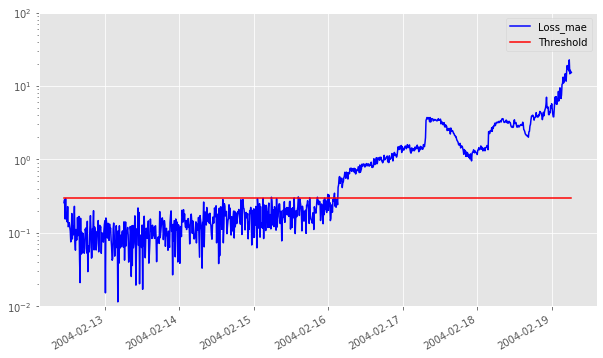

In [28]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

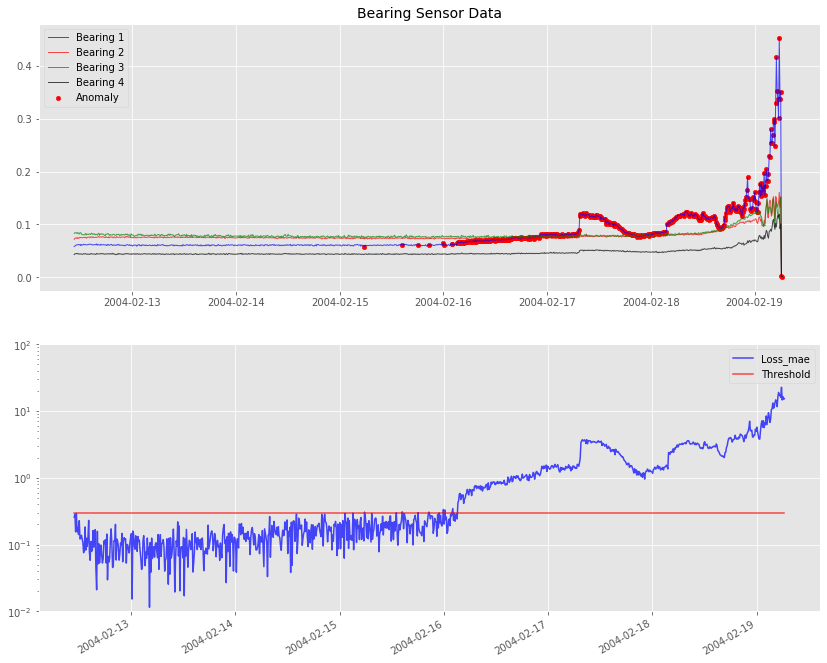

In [29]:
fig, (ax1, ax2) = plt.subplots(2,1,  figsize = (14 ,12))
ax1.plot(merged_data['Bearing 1'], label='Bearing 1', color='blue', alpha = 0.7, linewidth=1)
ax1.plot(merged_data['Bearing 2'], label='Bearing 2', color='red', alpha = 0.7, linewidth=1)
ax1.plot(merged_data['Bearing 3'], label='Bearing 3', color='green', alpha = 0.7, linewidth=1)
ax1.plot(merged_data['Bearing 4'], label='Bearing 4', color='black', alpha = 0.7, linewidth=1)
ax1.scatter(scored[scored['Anomaly']==True].index, 
            merged_data.loc[scored[scored['Anomaly']==True].index, 'Bearing 1'], color = 'red', label = 'Anomaly', s = 20)
ax1.legend(loc='best')
ax1.set_title('Bearing Sensor Data', fontsize=14)

scored.plot(logy=True, ylim = [1e-2,1e2], color = ['blue','red'], alpha = 0.7, ax = ax2)
plt.show()